<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/autoencoder-mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder on MNIST data with TensorFlow 2

* https://blog.keras.io/building-autoencoders-in-keras.html
* https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

font_size=15
title_font_size=25

# https://matplotlib.org/users/colormaps.html
from matplotlib.colors import ListedColormap

colors = ['#FF0000', '#0000FF', '#FFFF00']
cmap = ListedColormap(colors) 

In [2]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [0]:
tf.random.set_seed(42)

In [5]:
!nvidia-smi

Mon Dec 30 11:11:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve 

     |████████████████████████████████| 71kB 3.5MB/s 


In [0]:
from lrcurve import KerasLearningCurve

## MNIST data set

In [8]:
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist

x_res = 28
y_res = 28
image_size = x_res * y_res

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape, x_test.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

can not use 2d rep as autoencoder needs to spit out flat image

In [9]:
x_train = x_train.reshape(-1, image_size)
x_test = x_test.reshape(-1, image_size)
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [0]:
def plot_samples(x, y, n_samples=15, labels=None):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res), cmap="binary")
      if labels:
        ax.set_title("{}".format(labels[y[index]]))
      else:
        ax.set_title("{}".format(y[index]))

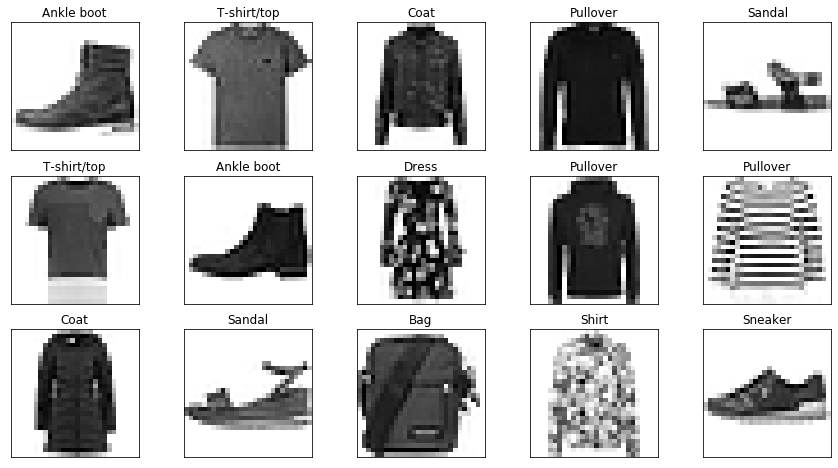

In [11]:
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9


plot_samples(x_train, y_train, labels=fashion_mnist_labels)

autoencoder using functional API

In [12]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.models import Model

encoding_dim = 32

# input_img = Input(shape=(28, 28), name='2d_input')
input_img = Input(shape=image_size, name='1d_input')
# flattened = Flatten(name='flattened_input')(input_img)
encoded = Dense(encoding_dim, activation='relu', name='encoder')(input_img)
decoded = Dense(image_size, activation='sigmoid', name='decoder')(encoded)
# reshaped = Reshape((28, 28), name='2d_output')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1d_input (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
encoder (Dense)              (None, 32)                25120     
_________________________________________________________________
decoder (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


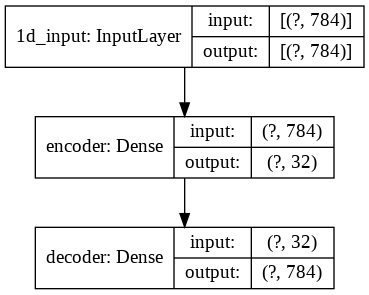

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(autoencoder, show_shapes=True, dpi=dpi)

In [0]:
from tensorflow import keras

@tf.function
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [0]:
KerasLearningCurve?

In [15]:
%%time 

BATCH_SIZE = 256
EPOCHS = 50

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[rounded_accuracy])
# also possible
# autoencoder.compile(optimizer='adam', loss='mse')

# we expect 0.09 for mninst and around 0.28 for fahshin mnist
history = autoencoder.fit(x = x_train,
                    y = x_train,
                    validation_data=(x_test, x_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 1min 11s, sys: 7.45 s, total: 1min 19s
Wall time: 55.5 s


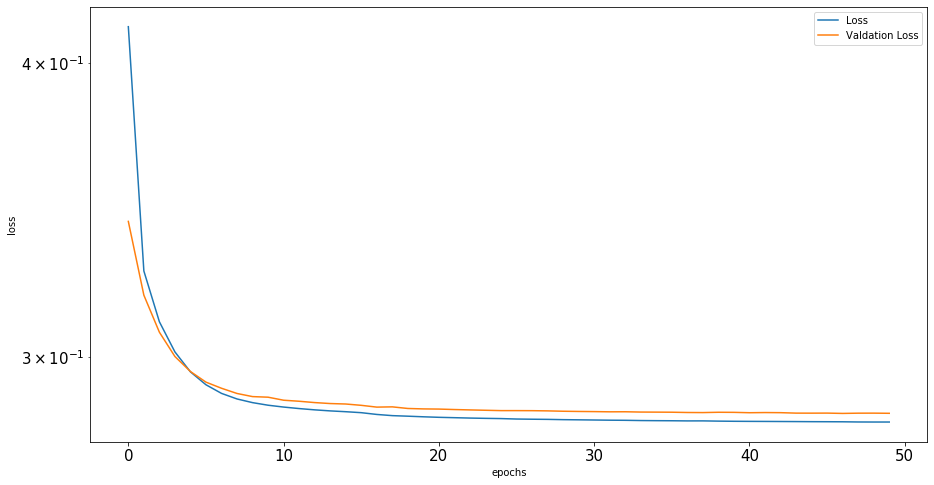

In [16]:
plt.yscale('log')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(["Loss", "Valdation Loss"]);

In [0]:
encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.get_layer('decoder')
decoder = Model(encoded_input, decoder_layer(encoded_input))

embedded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(embedded_imgs)

In [0]:
# shortcut
# x_test_pred = autoencoder.predict(x_test)
x_test_pred = decoded_imgs

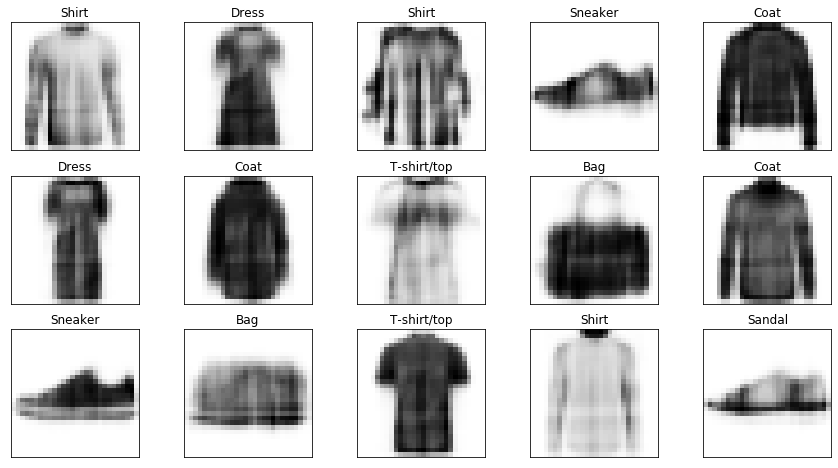

In [19]:
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

In [0]:
def compare_samples(x, x_pred, n_samples=5):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(2, n_samples, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res), cmap="binary")
      ax = figure.add_subplot(2, n_samples, i + 1 + n_samples, xticks=[], yticks=[])
      ax.imshow(x_pred[index].reshape(x_res, y_res), cmap="binary")

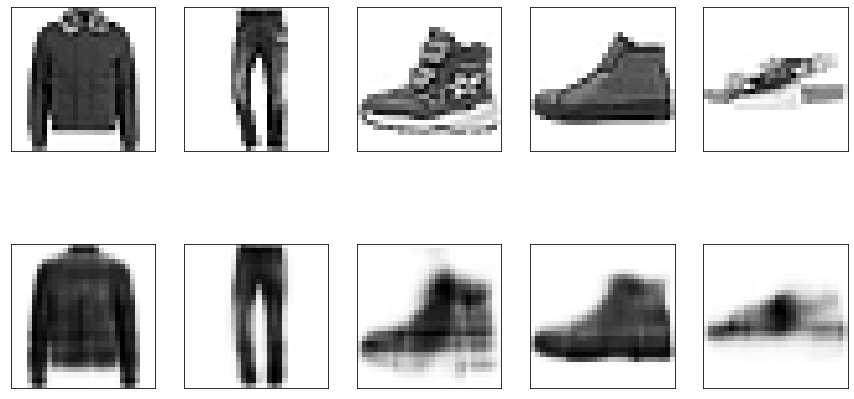

In [21]:
compare_samples(x_test, x_test_pred)

## let's consider the sparsity of an embedding 
### how big are the embeddings on avearge and how many zeros do the embeddings contain on average

In [22]:
embedded_imgs.shape

(10000, 32)

In [23]:
# embedding for first image
embedded_imgs[0]

array([ 3.1216502, 10.62429  ,  3.5537486,  0.       ,  2.4922352,
        2.6924567,  5.204978 ,  0.       ,  2.8153899,  5.122952 ,
        6.0841255,  8.633883 ,  7.725277 ,  6.4746943,  2.20189  ,
        3.2118416,  9.080655 ,  6.5401587,  8.108193 ,  8.285671 ,
        4.274337 ,  4.037285 ,  8.714014 ,  4.8574314,  2.361123 ,
        3.8677344,  5.9522266,  1.7980949,  3.362053 ,  7.1347237,
        0.8824091,  3.4524732], dtype=float32)

In [24]:
tf.reduce_mean(embedded_imgs)

<tf.Tensor: shape=(), dtype=float32, numpy=4.5804987>

In [25]:
# how many zeros do the embeddings contain on average
tf.reduce_mean(32 - tf.math.count_nonzero(embedded_imgs, axis=1))

<tf.Tensor: shape=(), dtype=int64, numpy=3>

## Exercise

Experiment with
* the size of the embedding
* MSE as a loss function
* mnist digits dataset instead of fashin mninst

# STOP HERE

## Adding sparsity

In [26]:
from tensorflow.keras import regularizers

encoding_dim = 32

input_img = Input(shape=(image_size,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(1e-3))(input_img)
decoded = Dense(784, activation='sigmoid', name='decoder')(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
decoder (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [27]:
%%time 

BATCH_SIZE = 256
EPOCHS = 100

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[rounded_accuracy])

# we expect 0.09 for mninst and around 0.28 for fahshin mnist
history = autoencoder.fit(x = x_train,
                    y = x_train,
                    validation_data=(x_test, x_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 2min 35s, sys: 16.2 s, total: 2min 51s
Wall time: 1min 53s


In [0]:
encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.get_layer('decoder')
decoder = Model(encoded_input, decoder_layer(encoded_input))

embedded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(embedded_imgs)

numbers of zeros should go up, while average should go down

In [29]:
# embedding for first image
embedded_imgs[0]

array([0.        , 0.        , 0.56296206, 0.        , 0.        ,
       0.        , 1.1273147 , 0.2137147 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02576398, 0.39933705, 0.22809647, 0.        ,
       0.18086258, 0.        , 0.88737464, 0.08281791, 0.13155705,
       0.77677613, 0.        , 0.        , 0.        , 0.        ,
       0.33975792, 0.        ], dtype=float32)

In [30]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(32 - tf.math.count_nonzero(embedded_imgs, axis=1))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.14774446>,
 <tf.Tensor: shape=(), dtype=int64, numpy=19>)

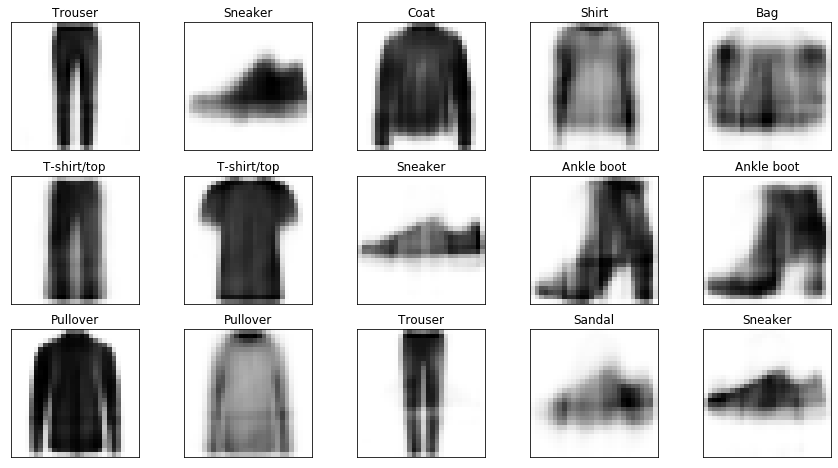

In [31]:
plot_samples(decoded_imgs, y_test, labels=fashion_mnist_labels)

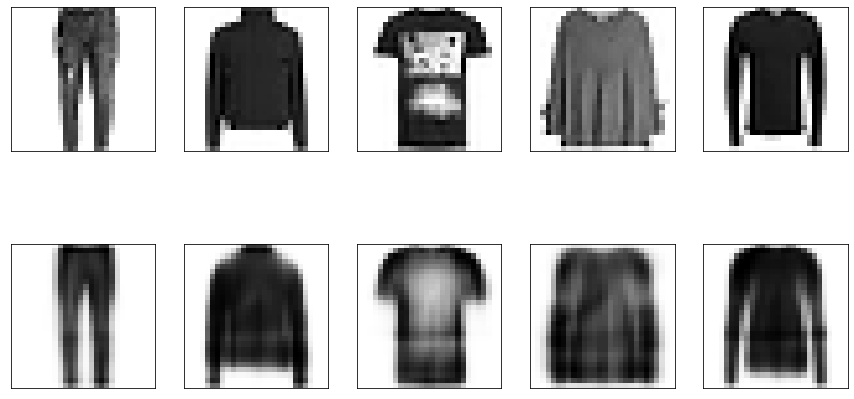

In [32]:
compare_samples(x_test, decoded_imgs)

## Deeper Autoencoder
https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [33]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [34]:
%%time

BATCH_SIZE = 256
EPOCHS = 20

encoding_dim = 32

stacked_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(x_res, y_res)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(encoding_dim, activation="relu", activity_regularizer=keras.regularizers.l1(5e-4)),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Input(shape=encoding_dim),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(image_size, activation="sigmoid"),
    keras.layers.Reshape((x_res, y_res))
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer='adam', metrics=[rounded_accuracy])
history = stacked_ae.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)


CPU times: user 33.8 s, sys: 3.36 s, total: 37.2 s
Wall time: 25.5 s


In [0]:
x_test_pred = stacked_ae.predict(x_test)

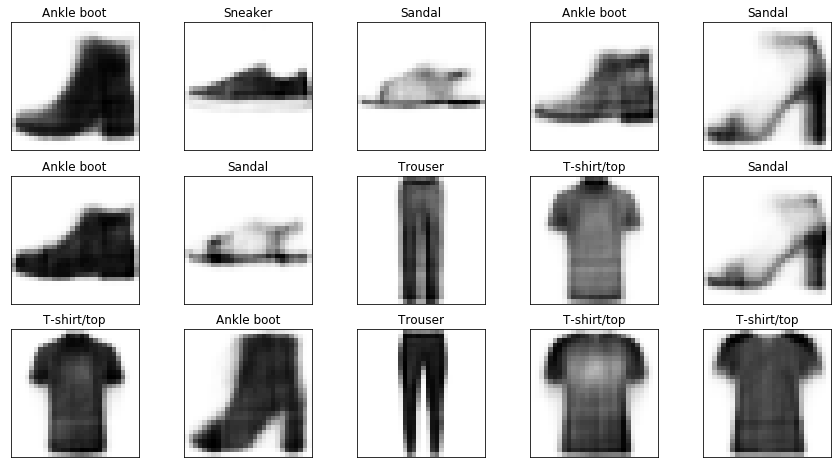

In [36]:
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

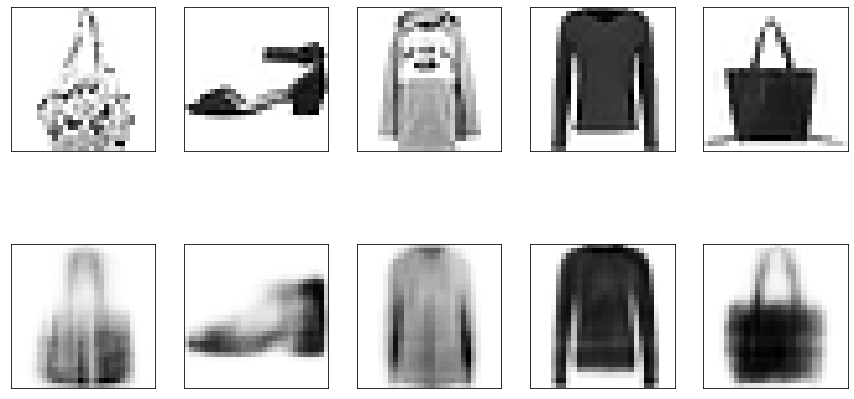

In [37]:
compare_samples(x_test, x_test_pred)

In [38]:
embedded_imgs = stacked_encoder.predict(x_test)
embedded_imgs.shape

(10000, 32)

In [39]:
embedded_imgs[0]

array([0.        , 0.        , 0.5834101 , 0.        , 0.05222738,
       0.        , 0.        , 0.21221903, 0.71600163, 0.        ,
       1.9389578 , 0.        , 0.        , 0.        , 2.3759916 ,
       0.        , 0.27787575, 0.15361793, 0.08260596, 0.        ,
       0.        , 0.31337985, 0.81675357, 0.        , 1.4186488 ,
       0.        , 0.39247614, 0.        , 0.        , 0.3478059 ,
       0.        , 0.        ], dtype=float32)

In [40]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(32 - tf.math.count_nonzero(embedded_imgs, axis=1))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.2701409>,
 <tf.Tensor: shape=(), dtype=int64, numpy=18>)

## Looking at our embeddings

In [0]:
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
# https://umap-learn.readthedocs.io/en/latest/how_umap_works.html
import umap

In [42]:
%%time

# https://umap-learn.readthedocs.io/en/latest/parameters.html
reducer = umap.UMAP(
#     n_neighbors=5, 
    random_state=42)
embeddings_2d = reducer.fit_transform(embedded_imgs)

CPU times: user 32.9 s, sys: 282 ms, total: 33.2 s
Wall time: 32.7 s


In [43]:
embeddings_2d.shape

(10000, 2)

In [44]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)
embeddings_2d.shape

(10000, 2)

(-1.279005496956694,
 1.8612097196358321,
 -2.1084139676302907,
 2.7135613293856617)

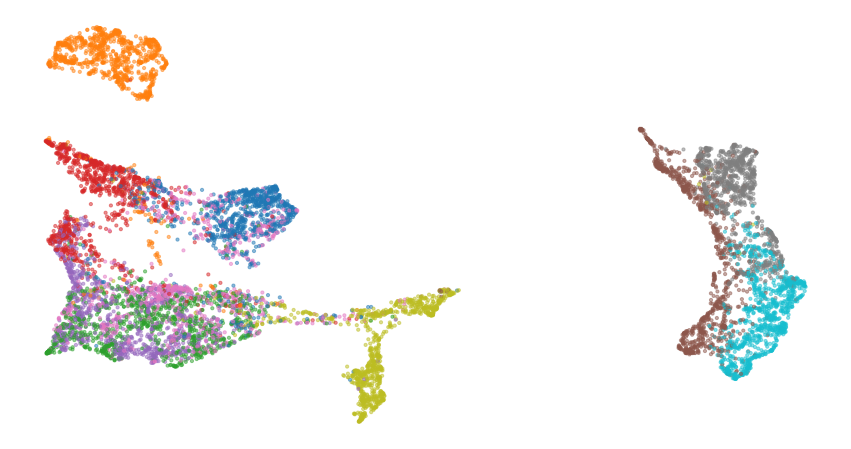

In [45]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap="tab10", alpha=0.5)
plt.axis("off")

(-1.279005496956694,
 1.8612097196358321,
 -2.1084139676302907,
 2.7135613293856617)

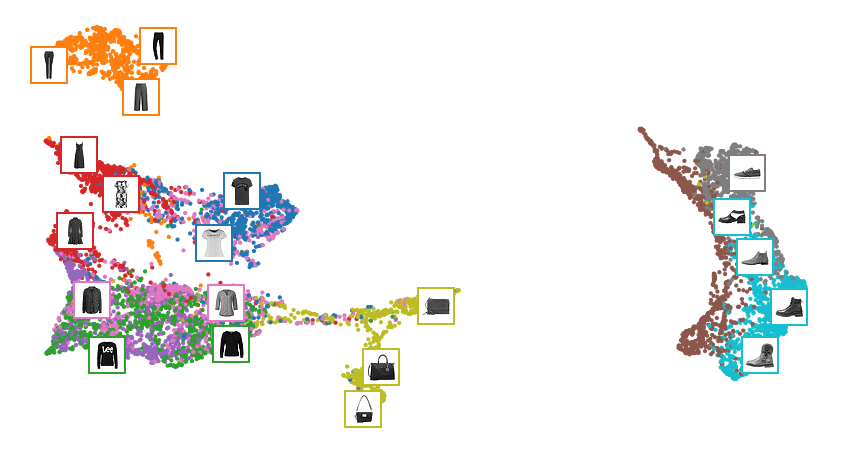

In [46]:
# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
cmap = plt.cm.tab10
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embeddings_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.2: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")

## Using 2d embeddings directly without UMAP dimensionality reduction

In [47]:
%%time

BATCH_SIZE = 2048
EPOCHS = 100

encoding_dim = 2

stacked_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(x_res, y_res)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(encoding_dim, activation="relu",
                       activity_regularizer=keras.regularizers.l1(1e-5)
                      )
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Input(shape=encoding_dim),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(image_size, activation="sigmoid"),
    keras.layers.Reshape((x_res, y_res))
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer='adam', metrics=[rounded_accuracy])
history = stacked_ae.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)


CPU times: user 49.2 s, sys: 3.35 s, total: 52.6 s
Wall time: 34.6 s


In [0]:
x_test_pred = stacked_ae.predict(x_test)

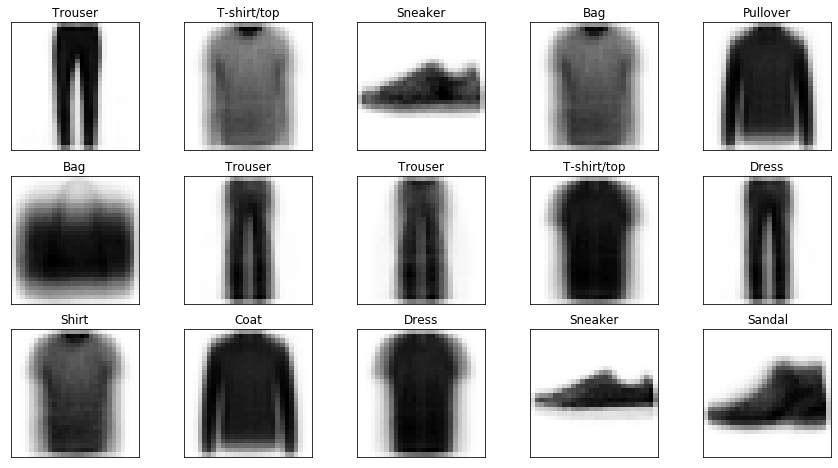

In [49]:
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

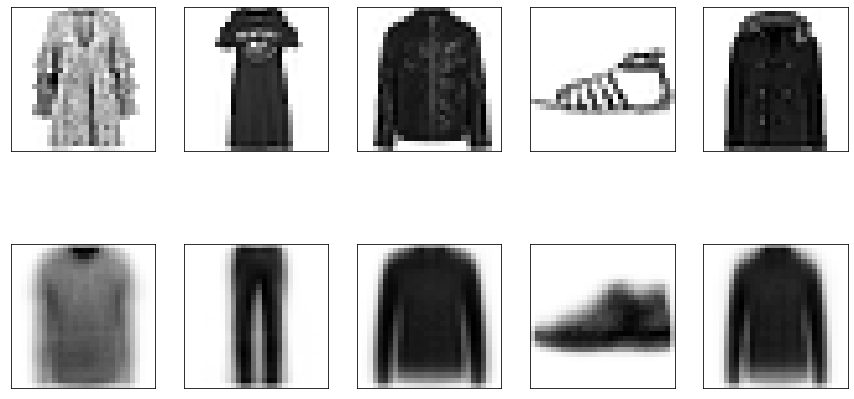

In [50]:
compare_samples(x_test, x_test_pred)

In [51]:
embedded_imgs = stacked_encoder.predict(x_test)
embedded_imgs.shape

(10000, 2)

In [52]:
embedded_imgs[0]

array([33.75499,  0.     ], dtype=float32)

In [53]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(2.0 - tf.cast(tf.math.count_nonzero(embedded_imgs, axis=1), tf.float32))

(<tf.Tensor: shape=(), dtype=float32, numpy=7.6472373>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0793>)

In [0]:
embeddings_2d = embedded_imgs

In [55]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)
embeddings_2d.shape

(10000, 2)

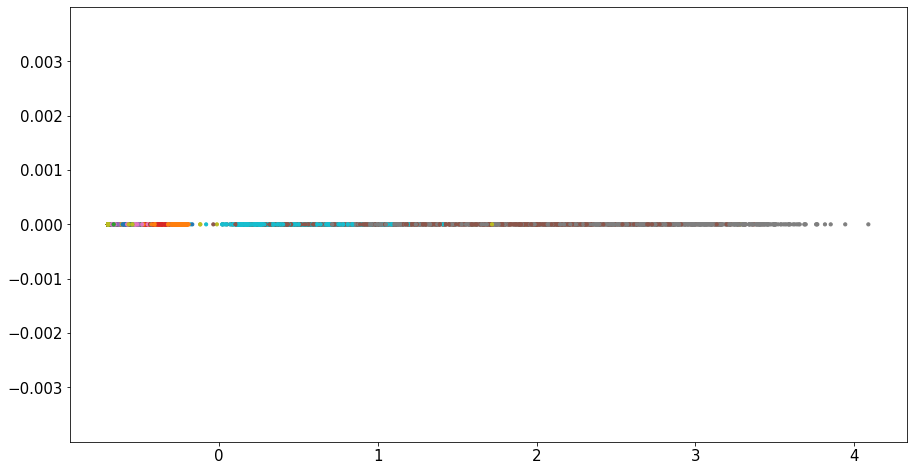

In [56]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)

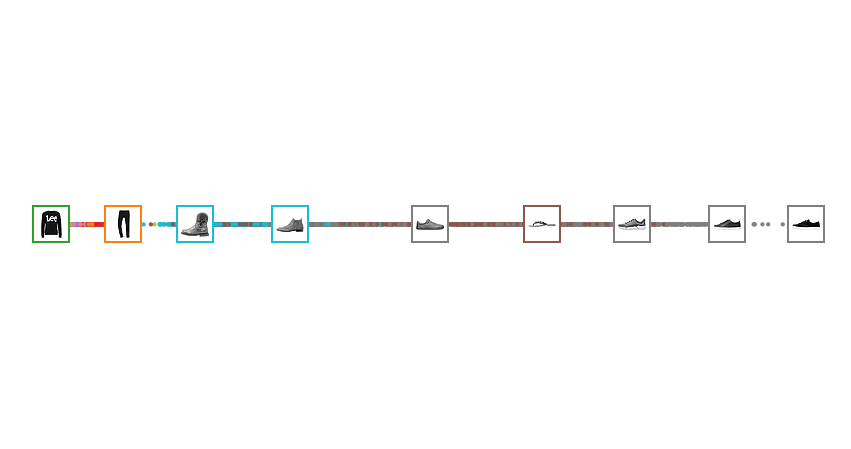

In [57]:
min_dist = 0.2

# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
cmap = plt.cm.tab10
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embeddings_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > min_dist: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off");

## Convolutional Autoencoders

In [93]:
x_train = x_train.reshape(-1, x_res, y_res, 1)
x_test = x_test.reshape(-1, x_res, y_res, 1)

x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [100]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential

BATCH_SIZE = 2048
EPOCHS = 100

encoding_dim = 2

encoder = Sequential([
    Input(shape=(x_res, y_res, 1)),
    Conv2D(filters=64, kernel_size=4, activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=4, activation='relu'),
    MaxPooling2D(),
#     Flatten(),
#     Dense(encoding_dim, activation="relu", activity_regularizer=keras.regularizers.l1(1e-5)),
])
decoder = Sequential([
#     Reshape((1, 1, encoding_dim)),
    UpSampling2D(),
    Conv2DTranspose(32, kernel_size=4, activation="relu"),
    UpSampling2D(),
    Conv2DTranspose(64, kernel_size=4, padding="same", activation="relu"),
    UpSampling2D(),
    Conv2DTranspose(1, kernel_size=6, activation="sigmoid"),
#     Reshape((x_res, y_res, 1))
])

autoencoder = Sequential([encoder, decoder])
autoencoder.compile(loss="binary_crossentropy",
                   optimizer='adam', metrics=[rounded_accuracy])

autoencoder.summary()

ValueError: ignored

In [101]:
history = autoencoder.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)

ValueError: ignored

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 32)        32800     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 3138      
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 1, None)      